 <h1 align='center'> COMP2420/COMP6420 - Introduction to Data Management, Analysis and Security</h1>

<h2 align='center'>Lecture 10 - ML and Plotting</h2>

In [1]:
# Authors: Alex Niven (classification), Afzal Ahmad (hyp. testing)
# Date: 28/03/2019
# Used for COMP2420 lecture on Friday 28 March

In [2]:
# Imports
import pandas as pd
import numpy as np
from itertools import combinations
from operator import itemgetter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import scipy.stats
import sklearn.metrics as skm
import matplotlib.pyplot as plt
## inline figures
%matplotlib inline

<h2 align='center'>Classifying Arrests - KNN Style</h2>

We will be looking at the arrests dataset originally found in R. This is a sample set of arrests from the US for Marijuana posession. While lecture 8 covered looking at the data, we now want to perform some classification on the data, but without going to the hastle of writing the functions manually

In [3]:
# Data read in
data = pd.read_csv('data/parrests.csv', index_col=0)
print("Column Names: ", data.columns.values)
data.head()


Column Names:  ['released' 'year' 'age' 'sex' 'employed' 'citizen' 'checks']


,released,year,age,sex,employed,citizen,checks
1,Yes,2002,21,Male,Yes,Yes,3
2,No,1999,17,Male,Yes,Yes,3
3,Yes,2000,24,Male,Yes,Yes,3
4,No,2000,46,Male,Yes,Yes,1
5,Yes,1999,27,Female,Yes,Yes,1


Our topic of interest here (our _labels_ or _y value_) is whether the suspects were **<u>released</u>** or not.

Our descriptive columns (our _features_ or _x values_) are:
- age
- sex
- employed
- citizen
- checks

-----------

Based on this information, we need to determine:
1. What data will be best to determine whether a suspect could be released (what features to use)
2. In our KNN model, what is the optimal number of neighbours to check? (k = ?)

#### 1. What data is best to use?

We can only tackle one question at a time here, otherwise we will have too many independent variables in play to determine a good model in reasonable time. While determining what data is best to use, we are going to use neighbours=5

In [4]:
# First: convert text to binary numerical values to make the classification a little easier
replacement_items = {"Male": 0, "Female": 1, "Yes": 1, "No": 0}
c_data = data.replace(replacement_items)
c_data.head()


,released,year,age,sex,employed,citizen,checks
1,1,2002,21,0,1,1,3
2,0,1999,17,0,1,1,3
3,1,2000,24,0,1,1,3
4,0,2000,46,0,1,1,1
5,1,1999,27,1,1,1,1


In [5]:
# Second: Seperate Data. What is the possible data we could use?
# Labels | Y values
y_labels = c_data['released']

# Features | X values
x_original = c_data.drop(['released'], axis=1)
possible_cols = [0,1,2,3,4,5]

combins = [list(combinations(possible_cols, x)) for x in range(1,7)]
#print(combins)
print([len(combins[x]) for x in range(0,6)])

[6, 15, 20, 15, 6, 1]


That could be a lot of possible combinations to test depending on our data set ! Lets pick a couple that we think could work

In [6]:
# Second v2. .... Choosing a couple of combinations of columns
test_batchs = [['age', 'sex', 'employed', 'citizen'], ['sex', 'age'], ['employed', 'citizen'], ['age', 'checks', 'citizen']]

accuracy_scores = []
# Third: Test based on score
for i in range(len(test_batchs)):
    x_train, x_test, y_train, y_test = train_test_split(x_original[test_batchs[i]], y_labels, test_size=0.1, random_state=3)
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(x_train, y_train)
    accuracy_scores.append([test_batchs[i], classifier.score(x_test, y_test)])


accuracy_scores = sorted(accuracy_scores, key=itemgetter(1), reverse=True)
print(accuracy_scores)

[[['employed', 'citizen'], 0.8145315487571702], [['sex', 'age'], 0.7934990439770554], [['age', 'sex', 'employed', 'citizen'], 0.7648183556405354], [['age', 'checks', 'citizen'], 0.7437858508604207]]


Surprisingly, only having a single column provides the best score ! Now lets check the metric scores

In [20]:
# Metrics 
# Test again, train again as the previous classifier would be overwritten in the for loop
final_fantatures = c_data[['employed', 'citizen']]

x_train, x_test, y_train, y_test = train_test_split(final_fantatures, y_labels, test_size=0.1)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_predictions = classifier.predict(x_test)

# Metrics
# Custom metrics from sklearn.metrics require the input of the ground truth values and the predicted values
prfs = skm.precision_recall_fscore_support(y_test, y_predictions, average='binary') # Various metrics
loss01 = skm.zero_one_loss(y_test, y_predictions) # Returns number of misclassifications unless normalisation used
cmat = skm.confusion_matrix(y_test, y_predictions) # Way easier than last lecture
print("Metrics")
print('Precision: ', prfs[0], ' .. Recall: ', prfs[1], ' .. fscore: ', prfs[2], ' .. Support: ', prfs[3])
print("0-1 loss: ", loss01)
print("Confusion Matrix")
print(cmat)

Metrics
Precision:  0.8202676864244742  .. Recall:  1.0  .. fscore:  0.9012605042016807  .. Support:  None
0-1 loss:  0.17973231357552577
Confusion Matrix
[[  0  94]
 [  0 429]]


So how did we do? What can we do better?

#### 2. How many neighbours?

We've determined a good use of feature columns, now lets determine the ideal number of neighbours.

We can perform cross validation scoring to determine what is the best _k_ value, based on accuracy.

Ideal k value:  7 .. based on accuracy score:  0.823580160109447


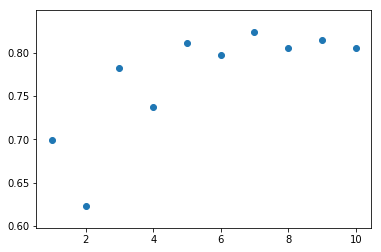

In [24]:
# Random data
features = c_data[['sex', 'age']]
y_labels = c_data['released']

results = []
for k in range(1,11):
    classifier = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classifier, features, y_labels, cv=10)
    results.append([k, np.mean(score)])

sorted_scores = sorted(results, key=itemgetter(1), reverse=True)
print('Ideal k value: ', sorted_scores[0][0], ".. based on accuracy score: ", sorted_scores[0][1])

#zip for graphing    
x1,y1 = zip(*results)
#graphing items
plt.figure()
plt.scatter(x1,y1)

Based on our above, we can see the ideal _k_ value is 7, so our model should check its 7 nearest neighbours to have the best result.

<h2 align='center'>Arrests - Decision trees</h2>

Thanks to the rich depth of python libraries, we are also able to explore classification using a decision tree !

Note, we will use all the columns except year to check the arrest result of our suspects, to give the tree function a good workout. Since most of our data is not continuous, the binary decision making of the tree makes the processsing quite fast.

In [9]:
# Dropping year & converting data to numerical
replacement_items = {"Male": 0, "Female": 1, "Yes": 1, "No": 0}
c_dt_data = data.replace(replacement_items)
c_dt_data = c_dt_data.drop(['year'], axis=1)
c_dt_data.head()

,released,age,sex,employed,citizen,checks
1,1,21,0,1,1,3
2,0,17,0,1,1,3
3,1,24,0,1,1,3
4,0,46,0,1,1,1
5,1,27,1,1,1,1


In [10]:
# Feature & label setting
# Labels | Y values
dty_labels = c_dt_data['released']

# Features | X values
dt_features = c_dt_data.drop(['released', 'age'], axis=1)

In [11]:
# Classification Time!
dt_classifier = DecisionTreeClassifier(criterion="entropy", presort=True)

dtx_train, dtx_test, dty_train, dty_test = train_test_split(dt_features, dty_labels, test_size=0.2)
dt_classifier.fit(dtx_train, dty_train)
applied = dt_classifier.apply(dtx_test)
print(applied)
dotf = export_graphviz(dt_classifier, out_file='out.dot')

[51 42 78 ... 36 51 51]


Now that we have a DOT file exported, we can convert it to a png in terminal using _dot -Tpng out.dot -o tree.png_ (provided you have graphwiz installed). Then, open and share to your hearts content !

------------
As with other classifiers, we can also evaluate the performance of the model

In [12]:
# Scoring

dt_score = dt_classifier.score(dtx_test, dty_test)
print(dt_score)

0.8202676864244742


Not too bad for accuracy for a first attempt !

-----------
## Hypothesis Testing
- The year is 2003. While watching the news, you see that a spokesperson for the police claims that, of the people arrested in 2002, the average age was "about 23", and that programs should be set up to help young adults and prevent crime at an earlier age.<br>
- Following the above claim, the spokesperson also said that the average age of arrests in 2002 was significantly lower than the average age in 2001.


We want to check whether these claims can be substantiated. Fortunately, we have all the data we need! We just need to do some hypothesis testing!

Before we jump into it, let's first get to know the distribution of our data. This is always important so that we can be clearer about what we're trying to show. First, we want to look at the distribution for age for arrests made in 2002.

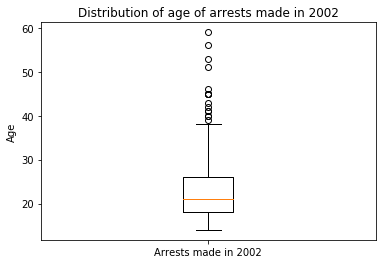

Mean: 23.36462093862816
# of arrests in 2002: 277


In [13]:
# distribution of age for arrests made in 2002
arr_2002 = c_data[c_data["year"] == 2002]

plt.boxplot(arr_2002["age"], labels=["Arrests made in 2002"])
plt.ylabel("Age")
plt.title("Distribution of age of arrests made in 2002")
plt.show()

# let's also look at the mean
print("Mean:", arr_2002["age"].mean())
print("# of arrests in 2002:", len(arr_2002))

Hmm, we have an actual mean of 23.36 years old, and we have a total number of 277 arrests in 2002. This number seems pretty close to 23, but let's do a rigorous test to make sure.

Here we have <b>one group of scores</b>, so we want to do a <b>t-test for 1 sample</b>. We check whether the dataset we present has a mean equal to the number we present. Before we code, we should <b>set up our hypotheses</b>.

<b>H0</b> (the "null hypothesis", or the "default" assumption): The mean age of arrests made in 2002 is equal to 23.<br>
<b>HA</b> (the "alternative hypothesis"): The mean age of arrests in 2002 is <b>significantly different</b> to 23.<br>
We should also note that we use a <b>significance level of alpha=0.05</b>.

Now we can get started!

In [14]:
# 1 sample t-test for average age of arrests in 2002 vs 23 years old
t, p = scipy.stats.ttest_1samp(arr_2002["age"], popmean=23)
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 0.7638091660066472
p-value: 0.4456334180698672


We see that the <b>p-value is above our significance level</b>, so we should <b>fail to reject the null hypothesis</b>. We do not say that we "accept" the null hypothesis, because there's a chance that we don't have enough data to show that they're significantly different. In general:

In [15]:
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: the mean age of arrests is significantly different to 23.")
else:
    print("Fail to reject the null hypothesis: the mean age of arrests is not significantly different to 23.")

Fail to reject the null hypothesis: the mean age of arrests is not significantly different to 23.


Note that the p-value is dependent on the <b>actual mean</b>, the <b>variance</b>, and <b>how much data we have</b>. The closer the actual mean to the hypothesised mean, the higher the p-value. Similarly, the higher the variance or the less data we have, the more "room for error" we have, so the p-value would be higher.

Now let's check on the second claim: that the average age of arrests in 2002 was significantly lower than that in 2001. This requires a <b>one-sided t-test for independent samples</b> - but our package doesn't have one-sided t-tests built in, so we need to work with it a little. Before we get started, let's have a look at the data.

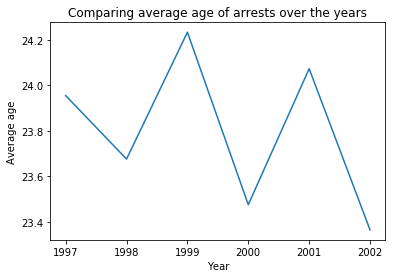

In [16]:
plt.plot(c_data.groupby("year")["age"].mean())
plt.xlabel("Year")
plt.ylabel("Average age")
plt.title("Comparing average age of arrests over the years")
plt.show()

Looks like it does drop from 2001 to 2002, but take note of the y-axis - it only drops by 0.7 or so. We should check this rigorously. Let's set up our hypotheses:

<b>H0</b>: The average ages of arrests made in 2001 and 2002 are equivalent to each other.<br>
<b>HA</b>: The average ages of arrests made in 2001 is significantly higher than in 2002.<br>
Again, we use a <b>significance level of alpha=0.05</b>.

In [17]:
arr_2001 = c_data[c_data["year"] == 2001]
# one-sided t-test for independent samples
t, p = scipy.stats.ttest_ind(arr_2001["age"], arr_2002["age"])
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 1.2591734020947434
p-value: 0.20816546049133108


Remember that we're doing a <b>one-sided t-test</b> so we need to <b>halve the p-value</b> so that we only consider values on one side (we ignore the possibility that the average age of arrests in 2002 is higher than 2001).

In [18]:
alpha = 0.05
if p/2 < alpha:
    print("Reject the null hypothesis: the average ages of arrests made in 2001 is significantly higher than in 2002.")
else:
    print("Fail to reject the null hypothesis: the average ages of arrests made in 2001 is not significantly higher than in 2002.")

Fail to reject the null hypothesis: the average ages of arrests made in 2001 is not significantly higher than in 2002.


A surprising result, considering the plot we have above! Still, we need to be careful - <b>we do not say that we "accept" the null hypothesis</b>, because having access to more data may give us clearer information.

To conclude, we say that we agree with the spokesperson that the average age of arrests in 2002 is equivalent to 23 years old, but..